<div style="text-align:left;">

# <span style="text-decoration: underline;"><b>Projet de fin de formation - DATAGONG</b></span>

</div>


## <b>Analyse e‑commerce 2023 vs 2024 — thelook_ecommerce </b>

### 1. Descriptions des variables

#### 1.1. Aperçu global du jeu de données et re-typage des données
Commençons par importer notre jeu de données sous format csv et le convertir en DataFrame.

In [2]:
import pandas as pd

# Chargement du fichier csv
df = pd.read_csv("../data/thelook_fr_women_2023_2024.csv")

# Dimensions du jeu de données
print(f'Le jeu de donnée fait {df.shape[0]} lignes et {df.shape[1]} colonnes')

# En-tête du jeu de données
df.head()

Le jeu de donnée fait 1679 lignes et 20 colonnes


,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
0,19425,28112,6983,2023-01-01 06:18:03+00:00,Shipped,29.500000,16.048000,Shorts,Women,Fox,Fox Juniors Momentum Short,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,15644,F,France,Centre-Val de Loire,Corquilleroy
1,19425,28113,10597,2023-01-01 06:44:58+00:00,Shipped,20.000000,10.000000,Intimates,Women,Wacoal,Wacoal Women's B-Smooth Bralette,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,15644,F,France,Centre-Val de Loire,Corquilleroy
2,4710,6730,11792,2023-01-03 04:44:50+00:00,Complete,38.000000,18.468000,Intimates,Women,American Apparel,American Apparel Striped Chiffon Tank,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris
3,16618,24006,329,2023-01-03 15:13:39+00:00,Complete,27.990000,16.402140,Tops & Tees,Women,Tri-Mountain,Tri-Mountain Women's 3/4-Sleeve Pique Knit Pol...,Complete,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,13422,F,France,Hauts-de-France,Comines
4,4710,6731,5295,2023-01-05 06:43:09+00:00,Complete,56.880001,29.577601,Pants & Capris,Women,Lauren by Ralph Lauren,Lauren Ralph Lauren Velour Pants,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris


Une fois notre DataFrame créé, intéressons-nous aux colonnes grace à la méthode .info de pandas, puis nous allons créer ensuite un dictionnaire les décrivant (définition, type, exemple).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          1679 non-null   int64  
 1   order_item_id     1679 non-null   int64  
 2   product_id        1679 non-null   int64  
 3   item_created_at   1679 non-null   object 
 4   item_status       1679 non-null   object 
 5   sale_price        1679 non-null   float64
 6   cost              1679 non-null   float64
 7   category          1679 non-null   object 
 8   department        1679 non-null   object 
 9   brand             1677 non-null   object 
 10  product_name      1679 non-null   object 
 11  order_status      1679 non-null   object 
 12  order_created_at  1679 non-null   object 
 13  shipped_at        1133 non-null   object 
 14  delivered_at      636 non-null    object 
 15  user_id           1679 non-null   int64  
 16  gender            1679 non-null   object 


On observe déjà que l'essentiel des valeurs manquantes se trouve dans les deux variables `shipped_at` et `delivered_at`, ce qui n'est pas surprenant si on considère qu'un certain nombre de commandes n'ont pas encore été expédiées et livrées au moment de l'extraction des bases.
Il existe également 2 valeurs manquantes pour la colonne brand.

On peut d'ores et déjà changer le type object en date pour les colonnes de date et en category pour les colonnes catégorielles . 

In [4]:
# Affichage des colonnes catégorielles
df.select_dtypes(include='object').head()

,item_created_at,item_status,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,gender,country,state,city
0,2023-01-01 06:18:03+00:00,Shipped,Shorts,Women,Fox,Fox Juniors Momentum Short,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,F,France,Centre-Val de Loire,Corquilleroy
1,2023-01-01 06:44:58+00:00,Shipped,Intimates,Women,Wacoal,Wacoal Women's B-Smooth Bralette,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,F,France,Centre-Val de Loire,Corquilleroy
2,2023-01-03 04:44:50+00:00,Complete,Intimates,Women,American Apparel,American Apparel Striped Chiffon Tank,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,F,France,Île-de-France,Paris
3,2023-01-03 15:13:39+00:00,Complete,Tops & Tees,Women,Tri-Mountain,Tri-Mountain Women's 3/4-Sleeve Pique Knit Pol...,Complete,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,F,France,Hauts-de-France,Comines
4,2023-01-05 06:43:09+00:00,Complete,Pants & Capris,Women,Lauren by Ralph Lauren,Lauren Ralph Lauren Velour Pants,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,F,France,Île-de-France,Paris


Les date sont au format objet, ce qui n'est pas très pratique pour trier notre DataFrame.
Nous allons commencer par parser les dates.

In [5]:
col_dates = ["item_created_at", "order_created_at", "shipped_at", "delivered_at"]

# Formatage de la date 
for c in col_dates:
    dates = pd.to_datetime(df[c], errors='coerce')
    df[c] = dates

Maintenant que les dates sont parsées, nous allons déterminer pour quelles colonnes il faudrait typer en category.

En effet, il n'est pas souhaitable de typer en category lorsqu'il y a un nombre trop important de modalités pour une colonne donnée. Cherchons alors à connaître le nombre de modalités uniques pour chaque colonne avec la méthode nunique.

In [6]:
for col in df.select_dtypes(include='object').columns.to_list():
    print(f'Colonne {col} : {df[col].nunique()}')

Colonne item_status : 5
Colonne category : 22
Colonne department : 1
Colonne brand : 657
Colonne product_name : 1559
Colonne order_status : 5
Colonne gender : 1
Colonne country : 1
Colonne state : 13
Colonne city : 547


 Les colonnes `brand` et `product_name` ont un nombre important de modalités uniques. Ainsi, nous les laisserons en format object.

 Changeons le type des autres colonnes catégorielles :

In [7]:
# Changement des type object en category pour les variables catégorielles
cat_list = ["item_status", "category", "department", "order_status", "gender", "country", "state", "city"]
df[cat_list] = df[cat_list].astype('category')

Finalement après toutes ces opérations, il est temps de re-contrôler le type de nos données.

In [8]:
# Contrôle du type des données
df.dtypes

order_id                          int64
order_item_id                     int64
product_id                        int64
item_created_at     datetime64[ns, UTC]
item_status                    category
sale_price                      float64
cost                            float64
category                       category
department                     category
brand                            object
product_name                     object
order_status                   category
order_created_at    datetime64[ns, UTC]
shipped_at          datetime64[ns, UTC]
delivered_at        datetime64[ns, UTC]
user_id                           int64
gender                         category
country                        category
state                          category
city                           category
dtype: object

Nos données catégorielles et de dates sont à présent bien typées. On créé maintenant notre dictionnaire de données permettant de décrire les colonnes.

#### 1.2. Création du dictionnaire de données
On va maintenant procéder à la création du du dictionnaire des données.

| Colonne           | Type                  | Définition                                                                 | Exemple                         |
|------------------|----------------------|---------------------------------------------------------------------------|---------------------------------|
| order_id         | int64                 | Identifiant unique de la commande. Une même commande peut contenir plusieurs lignes. | 19425                           |
| order_item_id    | int64                 | Identifiant unique de la ligne de commande (item).                        | 28112                           |
| product_id       | int64                 | Identifiant unique du produit vendu.                                       | 6983                            |
| item_created_at  | datetime64[ns, UTC]   | Date et heure de création de la ligne de commande.                         | 2023-01-01 06:18:03+00:00      |
| item_status      | category              | Statut de la ligne de commande (Shipped, Cancelled, Returned…).           | Shipped                         |
| sale_price       | float64               | Prix de vente facturé au client pour cette ligne de commande.             | 29.5                            |
| cost             | float64               | Coût interne du produit pour l’entreprise (achat ou production).          | 16.048                          |
| category         | category              | Catégorie du produit (Shorts, Tops & Tees…).                               | Shorts                          |
| department       | category              | Département / segment marché (Women).                                     | Women                           |
| brand            | object                | Marque du produit.                                                        | Fox                             |
| product_name     | object                | Nom commercial du produit.                                                | Fox Juniors Momentum Short      |
| order_status     | category              | Statut global de la commande (Shipped, Processing, Cancelled…).           | Shipped                         |
| order_created_at | datetime64[ns, UTC]   | Date de création de la commande.                                           | 2022-12-29 10:00:00+00:00      |
| shipped_at       | datetime64[ns, UTC]   | Date d’expédition de la commande ou de la ligne.                          | 2022-12-30 11:29:00+00:00      |
| delivered_at     | datetime64[ns, UTC]   | Date de livraison au client.                                              | 2023-01-04 03:03:00+00:00      |
| user_id          | int64                 | Identifiant unique du client.                                             | 15644                           |
| gender           | category              | Genre déclaré du client.                                                  | F                               |
| country          | category              | Pays de livraison.                                                        | France                          |
| state            | category              | Région / État de livraison.                                              | Centre-Val de Loire             |
| city             | category              | Ville de livraison.                                                       | Corquilleroy                    |


### 2. Contrôle de qualité des données

#### 2.1. Traitement des doublons
On va chercher dans un premier temps à voir s'il existe des observations intégralement dupliquées.

In [9]:
# Recherche d'observations intégralement dupliquées 
print(f"Il y a {df.duplicated().sum()} ligne(s) intégralement dupliquée(s)")

Il y a 0 ligne(s) intégralement dupliquée(s)


On voit qu'il n'y a aucune ligne intégralement dupliquée. Or, chaque ligne correspond à un article commandé.
L’unicité de `order_item_id` confirme donc l’absence de doublons métier.

#### 2.2. Traitement des valeurs manquantes
On va maintenant chercher à savoir s'il existe des valeurs manquantes et comment les traiter. On a vu que pour certains champs comme `shipped_at` et `delivered_at`, il était normal d'avoir des valeurs manquantes, il sera préférable de les laisser simplement en NaT. 

On en observe en revanche deux dans le champ `brand`. Cherchons alors la meilleure méthode d'imputation pour ces deux observations. 

In [10]:
# Affichage des observations où on a pas d'information concernant la variable brand
df[df["brand"].isna()]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,NaN,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,NaN,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Une première stratégie d'imputation serait de chercher si ces produits se retrouvent ailleurs dans le DataFrame et leur imputer la valeur de brand d'un hypothétique même produit.

In [11]:
# Identification des product_id dont la marque est manquante
missing_brand_products = df.loc[df["brand"].isna(), "product_id"].unique()

# Vérification de s'ils apparaissent ailleurs dans le dataset
df[df["product_id"].isin(missing_brand_products)] \
  .sort_values("product_id")


,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,NaN,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,NaN,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Ces produits sont uniques, on ne peut donc pas imputer avec la valeur de brand hypothétique. On va donc se contenter de remplacer par *"missing"*.

In [12]:
# Imputation par missing
df.fillna({"brand": "missing"}, inplace=True)

# Affichage des observations où on a pas d'information concernant la variable brand
df[df["brand"]=="missing"]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,missing,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,missing,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Les valeurs manquantes concernent principalement les dates de livraison et d’expédition, ce qui est cohérent avec des commandes non encore livrées ou annulées.
La variable brand présente deux valeurs manquantes, imputées comme “missing” faute d’information disponible ailleurs dans le jeu de données.

#### 2.3. Cohérence des bornes temporelles


Les dates sont maintenant au bon format. On voit cependant qu'il existe des outliers car certaines bornes temporelles sont avant 2023 et certaines après 2024.
Le périmètre d’analyse métier porte sur les commandes créées en 2023–2024.
Les dates de livraison ou d’expédition peuvent logiquement dépasser ce périmètre sans remettre en cause l’analyse. On va donc filtrer sur `order_created_at`.

In [13]:
print(f"La date la plus ancienne de order_created_at est : {df["order_created_at"].min()} \nLa date la plus récente de order_created_at est : {df["order_created_at"].max()}\n")
print(f"Colonne order_created_at : {(df["order_created_at"] < '2023-01-01 00:00:00+00:00').sum()} dates antérieures à 2023 et {(df["order_created_at"] > '2025-01-01 00:00:00+00:00').sum()} postérieures à 2024\n")
    

La date la plus ancienne de order_created_at est : 2022-12-29 10:00:00+00:00 
La date la plus récente de order_created_at est : 2024-12-31 05:13:00+00:00

Colonne order_created_at : 2 dates antérieures à 2023 et 0 postérieures à 2024



On voit que 2 commandes ont été créées fin 2022. on va donc les supprimer du jeu de données.

In [14]:
# Suppression des observations dont la commande a été passée avant 2023
df.drop(
    df[df["order_created_at"] < "2023-01-01"].index,
    inplace=True
)


In [15]:
print(f"La date la plus ancienne de order_created_at est : {df["order_created_at"].min()} \nLa date la plus récente de order_created_at est : {df["order_created_at"].max()}\n")
print(f"Colonne order_created_at : {(df["order_created_at"] < '2023-01-01 00:00:00+00:00').sum()} dates antérieures à 2023 et {(df["order_created_at"] > '2025-01-01 00:00:00+00:00').sum()} postérieures à 2024\n")

La date la plus ancienne de order_created_at est : 2023-01-03 08:12:00+00:00 
La date la plus récente de order_created_at est : 2024-12-31 05:13:00+00:00

Colonne order_created_at : 0 dates antérieures à 2023 et 0 postérieures à 2024



Nous avons désormais mis en forme et nettoyé nos données. Nous avons également redéfini nos bornes temporelles pour correspondre à la demande Métier. Il est temps à présent de se lancer dans l'exploration descriptive.

### 3. Explorations descriptives

#### 3.1. Distribution des données de prix de vente et de coût
Commençons tout d'abord par avoir une idée de la distribution des données liées aux prix de vente et au coût des produits. Utilisons pour cela la méthode describe().

In [16]:
df[["sale_price", "cost"]].describe()

,sale_price,cost
count,1677.000000,1677.000000
mean,57.060256,27.477283
std,69.714693,31.869373
min,1.820000,0.749840
25%,19.990000,9.666000
50%,38.000000,18.240000
75%,68.000000,33.275839
max,903.000000,437.052001


On peut déjà remarquer que les distributions des données de prix de vente et de coût ont le même profil, leur moyenne est supérieure à leur médiane et leur écart-type est supérieur à la moyenne, ce qui signifie un certain nombre de valeurs élévées.

Visualisons nos données avec des boxplot de manière à mieux visualiser les distributions.

C:\Users\New\AppData\Local\Temp\ipykernel_3128\1313833160.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


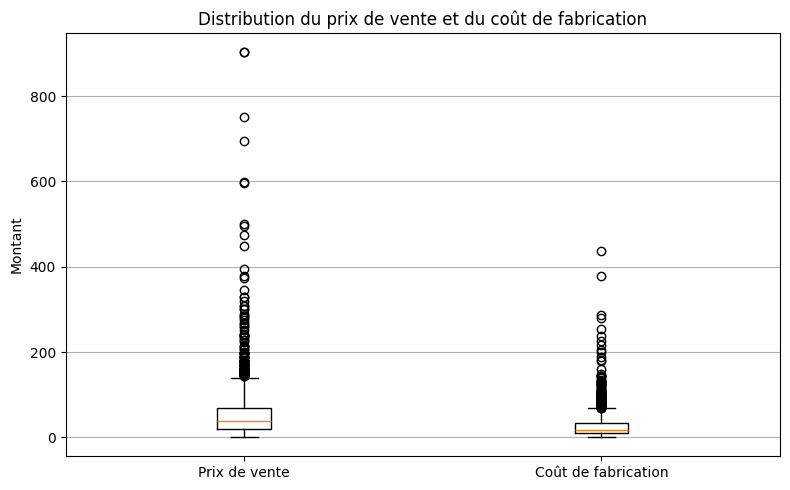

In [17]:
import matplotlib.pyplot as plt

data = [
    df["sale_price"],
    df["cost"]
]

plt.figure(figsize=(8, 5))
plt.boxplot(
    data,
    labels=["Prix de vente", "Coût de fabrication"],
)

plt.title("Distribution du prix de vente et du coût de fabrication")
plt.ylabel("Montant")
plt.tight_layout()
plt.grid(axis="y")
plt.show()


On note ici la présence importante d'outliers. Ces outliers sont des valeurs normales d'un point de vue métier, il n'est donc pas question de supprimer ces observations.

Nous pouvons également représenter nos données avec un histogramme et la librairie seaborn.

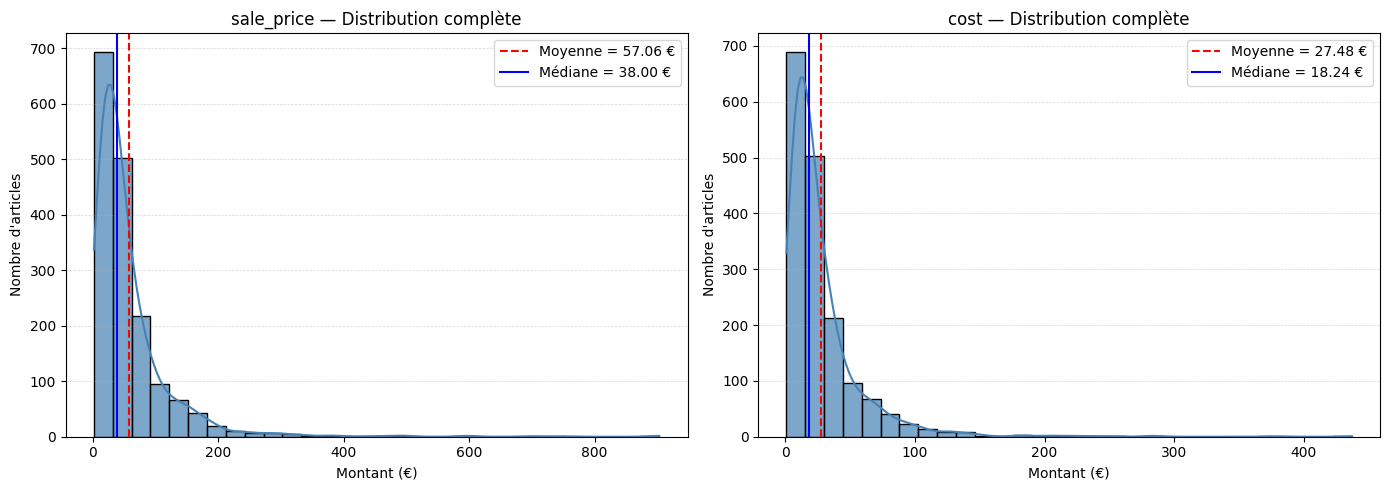

In [18]:
import seaborn as sns

# Colonnes
colonnes = ["sale_price", "cost"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, colonnes):
    x = df[col]

    # Statistiques
    mean = x.mean()
    median = x.median()

    # Histogramme
    sns.histplot(
        x,
        bins=30,
        edgecolor="black",
        alpha=0.7,
        kde=True,
        color="steelblue",
        ax=ax
    )

    # Lignes moyenne et médiane
    ax.axvline(mean, linestyle="--", color="red", label=f"Moyenne = {mean:.2f} €")
    ax.axvline(median, linestyle="-", color="blue", label=f"Médiane = {median:.2f} €")

    # Grille
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    # Titres et labels
    ax.set_title(f"{col} — Distribution complète")
    ax.set_xlabel("Montant (€)")
    ax.set_ylabel("Nombre d'articles")
    ax.legend()

plt.tight_layout()
plt.show()


Les histogrammes confirment que les données de prix de ventes et de coûts ont une structure similaire mais centrée sur une médiane plus grande pour les données de prix de ventes, ce qui est normal et correspond à la marge brute.


De plus, on constate que les distributions du prix de vente et du coût de fabrication présentent une forte asymétrie à droite, caractérisée par des moyennes supérieures aux médianes. La majorité des articles se situe dans des gammes de prix modérées, tandis qu’un nombre limité de produits à prix élevé génère une dispersion importante et des valeurs extrêmes. Cette structure est cohérente avec un catalogue e-commerce multi-gammes incluant des produits à forte valeur commerciale.

#### 3.2. Contribution par marque, catégorie, ville, saisonnalité mensuelle 
Maintenant nous allons nous intéresser à la contribution au chiffre d'affaire global sur 2023-2024 des marques, catégories, zones géographiques et selon le mois de l'année.


In [19]:
df.groupby('brand')['sale_price'].sum().sort_values(ascending=False).head()


brand
The North Face       2711.990005
Jones New York       2386.479980
7 For All Mankind    2124.490009
Calvin Klein         1851.349998
Ray-Ban              1722.780006
Name: sale_price, dtype: float64

In [20]:
df.groupby('category')['sale_price'].sum().sort_values(ascending=False)

C:\Users\New\AppData\Local\Temp\ipykernel_3128\1873350035.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('category')['sale_price'].sum().sort_values(ascending=False)


category
Outerwear & Coats                10073.570000
Dresses                           9355.120023
Jeans                             8618.090036
Intimates                         8220.940010
Swim                              6253.950005
Fashion Hoodies & Sweatshirts     5369.269993
Sleep & Lounge                    4943.630011
Pants & Capris                    4575.610018
Sweaters                          4460.350011
Blazers & Jackets                 4407.120020
Maternity                         4308.429986
Active                            3954.770009
Tops & Tees                       3859.460004
Plus                              3424.170008
Accessories                       3352.959988
Shorts                            3166.580026
Skirts                            2452.949994
Suits                             1759.539989
Leggings                          1146.330002
Socks & Hosiery                    973.550002
Jumpsuits & Rompers                829.670005
Clothing Sets            

In [21]:
df.groupby('city')['sale_price'].sum().sort_values(ascending=False).head()


C:\Users\New\AppData\Local\Temp\ipykernel_3128\1928866368.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('city')['sale_price'].sum().sort_values(ascending=False).head()


city
Paris                     4762.090030
Marseille                 2296.680001
Lyon                      1080.810001
Caluire-et-Cuire          1012.849985
Sainte-Gemme-la-Plaine     987.879997
Name: sale_price, dtype: float64

In [22]:
df["month"] = df["order_created_at"].dt.month
df.groupby('month')['sale_price'].sum()

month
1      6125.910012
2      6269.369999
3      4584.579976
4      7476.410015
5      7571.660010
6      9337.400027
7      5929.830009
8      8144.600004
9      9898.720007
10    11823.710015
11     8608.830030
12     9919.030035
Name: sale_price, dtype: float64

Le chiffre d’affaires est fortement concentré sur un nombre restreint de marques, de catégories et de villes, ce qui rend une visualisation exhaustive peu lisible à ce stade.

### 4. Comparaison 2023 vs 2024

A présent, voyons l'évolution mensuelle des ventes sur les années 2023 et 2024.

In [23]:
# Création des colonnes year et month du passage des commandes
df["year"] = df["order_created_at"].dt.year
df["month"] = df["order_created_at"].dt.month
df.head()

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,...,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city,month,year
2,4710,6730,11792,2023-01-03 04:44:50+00:00,Complete,38.000000,18.468000,Intimates,Women,American Apparel,...,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris,1,2023
3,16618,24006,329,2023-01-03 15:13:39+00:00,Complete,27.990000,16.402140,Tops & Tees,Women,Tri-Mountain,...,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,13422,F,France,Hauts-de-France,Comines,1,2023
4,4710,6731,5295,2023-01-05 06:43:09+00:00,Complete,56.880001,29.577601,Pants & Capris,Women,Lauren by Ralph Lauren,...,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris,1,2023
5,46318,67305,7623,2023-01-06 12:11:40+00:00,Processing,119.000000,49.980000,Blazers & Jackets,Women,Ulla Popken,...,2023-01-06 13:47:00+00:00,NaT,NaT,37166,F,France,Normandie,Le Havre,1,2023
6,40644,58981,5553,2023-01-08 07:08:05+00:00,Complete,49.990002,26.044791,Pants & Capris,Women,Sutton Studio,...,2023-01-08 08:55:00+00:00,2023-01-10 07:35:00+00:00,2023-01-10 14:42:00+00:00,32624,F,France,Île-de-France,Paris,1,2023


In [24]:
# Evaluation du CA par année
df.groupby("year")["sale_price"].sum()

year
2023    40781.840029
2024    54908.210110
Name: sale_price, dtype: float64

Tout d'abord on remarque rapidement que le chiffre d'affaires a significativement augmenté en 2024 par rapport à 2023. Regardons à présent le détail mois par mois.

In [25]:
# Création du dataframe regroupant les ventes par mois et années
monthly_ca = (
    df.groupby(["year", "month"])["sale_price"]
      .sum()
      .reset_index()
)

# Basculement du dataframe regroupant les ventes par mois et années
monthly_ca_pivot = monthly_ca.pivot(
    index="month",
    columns="year",
    values="sale_price"
)
monthly_ca_pivot

year,2023,2024
month,,
1,2315.510011,3810.400001
2,2621.729992,3647.640007
3,2241.819993,2342.759983
4,4050.459992,3425.950023
5,3422.949999,4148.710011
6,3833.690012,5503.710015
7,1959.970003,3969.860006
8,3402.479999,4742.120005
9,4446.080003,5452.640004


Nous avons une table représentant l'évolution mensuelle des ventes. Nous pouvons rajouter le différentiel mois à mois entre les deux années.

In [26]:
# Ajout de la variation absolue de chiffre d'affaires mois à mois
monthly_ca_pivot["delta_abs"] = (
    monthly_ca_pivot[2024] - monthly_ca_pivot[2023]
)

# Ajout de la variation reltive de chiffre d'affaires mois à mois
monthly_ca_pivot["delta_rel_pct"] = (
    monthly_ca_pivot["delta_abs"] / monthly_ca_pivot[2023]
) * 100
monthly_ca_pivot

year,2023,2024,delta_abs,delta_rel_pct
month,,,,
1,2315.510011,3810.400001,1494.889991,64.559859
2,2621.729992,3647.640007,1025.910016,39.131033
3,2241.819993,2342.759983,100.939990,4.502591
4,4050.459992,3425.950023,-624.509970,-15.418248
5,3422.949999,4148.710011,725.760012,21.202764
6,3833.690012,5503.710015,1670.020003,43.561686
7,1959.970003,3969.860006,2009.890003,102.546978
8,3402.479999,4742.120005,1339.640007,39.372458
9,4446.080003,5452.640004,1006.560002,22.639269


Il serait maintenant intéressant d'afficher le tout sur un graphe de manière à mieux visualiser les pics ou creux.

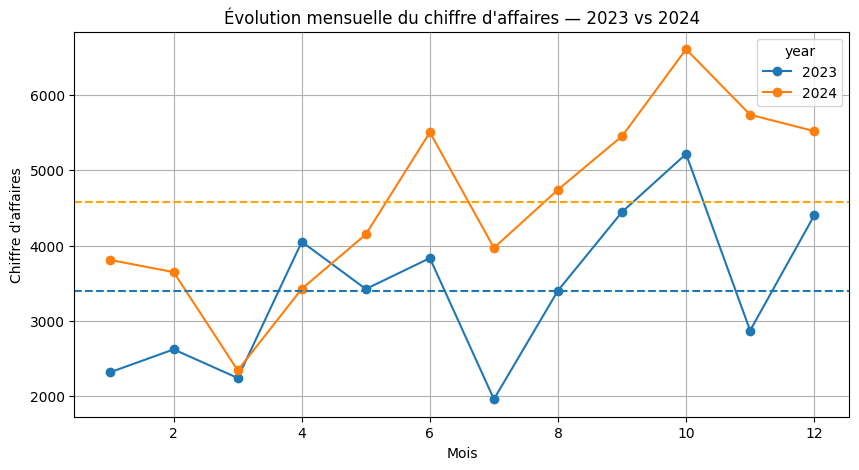

In [27]:
mean_2023 = monthly_ca_pivot[2023].mean()
mean_2024 = monthly_ca_pivot[2024].mean()

monthly_ca_pivot[[2023, 2024]].plot(
    kind="line",
    marker="o",
    figsize=(10, 5)
)

plt.title("Évolution mensuelle du chiffre d'affaires — 2023 vs 2024")
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaires")
plt.axhline(mean_2023, linestyle="--", label=f"Moyenne = {mean_2023:.2f} €")
plt.axhline(mean_2024, linestyle="--", color='orange', label=f"Moyenne = {mean_2023:.2f} €")
plt.grid(True)
plt.show()


On observe globalement une tendance similaire annuelle quand aux périodes de forte activité (pics Juin et Octobre) et creux (Mars et Juillet)

### 4. KPI Python

Pour finir notre EDA Python, calculons et affichons quelques indicateurs clés de la performance globale.

Chiffre d’affaires (somme de sale_price pour les lignes de vente) :

In [53]:
# Affichage du chiffre d'affaires
ventes = df[df["item_status"] == "Complete"]
ca_total = ventes.groupby("year")["sale_price"].sum()
ca_total


year
2023     7806.319998
2024    15716.280016
Name: sale_price, dtype: float64

Marge brute (somme de sale_price – cost pour les lignes de vente) :

In [122]:
# Affichage de la marge brute
cost_total = ventes.groupby("year")["cost"].sum()
marge_brute = ca_total - cost_total
marge_brute

year
2023    4075.343987
2024    8134.606315
dtype: float64

Nous pouvons calculer le taux de marge brute. Taux de Marge brute = Marge brute/CA.

In [57]:
# Calcul du taux de marge brute
taux_marge_brute = (ca_total-cost_total)/(ca_total)
taux_marge_brute

year
2023    0.522057
2024    0.517591
dtype: float64

Panier moyen (CA / nombre de commandes avec revenu > 0) :

In [65]:
# Calcul du panier moyen par commande
panier_moyen = ventes.groupby(["year", "order_id"])["sale_price"].sum().groupby("year").mean()
panier_moyen

year
2023    80.477526
2024    85.414565
Name: sale_price, dtype: float64

Taux de retour (part des lignes au statut Returned parmi les lignes vendues : ventes + retours) :
Ici, on travaille sur les lignes de de ventes qui correspondent aux articles des commandes, on va donc travailler avec `item_status` qui présente 5 modalités. On va alors considérés les arcticles vendus comme ayant le statut shipped ou complete.

In [86]:
# Lignes vendues + retournées
ventes_retour = df[df["item_status"].isin(["Returned", "Complete"])]

# Affichage du taux de retour
taux_retour_par_an = (ventes_retour.assign(is_return=ventes_retour["item_status"] == "Returned").groupby("year")["is_return"].mean())
taux_retour_par_an

year
2023    0.378723
2024    0.304239
Name: is_return, dtype: float64

Taux de ré‑achat (part des clients ayant ≥ 2 commandes complètes sur une année) :

In [89]:
# Passage au niveau commande
orders = (
    df.groupby("order_id")
      .agg(
          user_id=("user_id", "first"),
          order_created_at=("order_created_at", "first"),
          order_status=("order_status", "first")
      )
      .reset_index()
)

# Année de commande
orders["year"] = orders["order_created_at"].dt.year

# Commandes complètes
commandes_completes = orders[
    orders["order_status"].isin(["Complete", "Shipped"])
]

# Calcul et affichage du taux de ré-achat par année
for year in [2023, 2024]:
    o_year = commandes_completes[commandes_completes["year"] == year]
    
    nb_cmd_par_client = (
        o_year.groupby("user_id")["order_id"]
              .nunique()
    )
    
    taux_reachat = (nb_cmd_par_client >= 2).mean() * 100
    
    print(f"Taux de ré-achat {year} : {taux_reachat:.2f} %")


Taux de ré-achat 2023 : 4.82 %
Taux de ré-achat 2024 : 10.42 %


Cette analyse exploratoire a permis d’identifier les grandes dynamiques de chiffre d’affaires, de marge et de comportement client.
Les analyses de contribution détaillées (marques, villes) seront approfondies dans le tableau de bord Power BI.

In [141]:
# Chargement du fichier csv
DataFrame = pd.read_csv("../sql/data/csv_BigQuery.csv")

# Dimensions du jeu de données
print(f'Le jeu de donnée fait {DataFrame.shape[0]} lignes et {DataFrame.shape[1]} colonnes')

# En-tête du jeu de données
DataFrame.head()

Le jeu de donnée fait 1591 lignes et 20 colonnes


,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
0,61125,88932,4929,2023-01-01 08:54:29.000000 UTC,Shipped,198.000000,97.614000,Jeans,Women,Diesel,Diesel Women's Louvboot Slim Flare Jean,Shipped,2022-12-30 12:19:09.000000 UTC,2023-01-01 09:32:09.000000 UTC,NaN,48614,F,France,Île-de-France,Ivry-sur-Seine
1,61125,88931,5191,2023-01-02 08:44:55.000000 UTC,Shipped,42.990002,22.741711,Pants & Capris,Women,LOTUSTRADERS,BLACK PANT GAUCHOS RUFFLE TIERS WIDE - FITS (O...,Shipped,2022-12-30 12:19:09.000000 UTC,2023-01-01 09:32:09.000000 UTC,NaN,48614,F,France,Île-de-France,Ivry-sur-Seine
2,61125,88930,6675,2023-01-03 11:57:34.000000 UTC,Shipped,65.000000,35.620000,Shorts,Women,KUT from the Kloth,KUT from the Kloth Women's Bermuda Trouser Short,Shipped,2022-12-30 12:19:09.000000 UTC,2023-01-01 09:32:09.000000 UTC,NaN,48614,F,France,Île-de-France,Ivry-sur-Seine
3,6107,8932,15244,2023-01-06 23:35:33.000000 UTC,Processing,12.990000,6.533970,Plus,Women,Scarf_tradinginc,Scarf_tradinginc Elegant Paisley Jacquard Pash...,Processing,2023-01-07 00:17:39.000000 UTC,NaN,NaN,4905,F,France,Grand Est,Laxou
4,101416,147699,11629,2023-01-07 21:33:19.000000 UTC,Shipped,45.000000,25.920000,Intimates,Women,By The Sword Inc.,Renaissance Classic Chemise,Shipped,2023-01-06 22:16:57.000000 UTC,2023-01-08 03:38:57.000000 UTC,NaN,80975,F,France,Provence-Alpes-Côte d'Azur,Marseille


In [142]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591 entries, 0 to 1590
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          1591 non-null   int64  
 1   order_item_id     1591 non-null   int64  
 2   product_id        1591 non-null   int64  
 3   item_created_at   1591 non-null   object 
 4   item_status       1591 non-null   object 
 5   sale_price        1591 non-null   float64
 6   cost              1591 non-null   float64
 7   category          1591 non-null   object 
 8   department        1591 non-null   object 
 9   brand             1588 non-null   object 
 10  product_name      1591 non-null   object 
 11  order_status      1591 non-null   object 
 12  order_created_at  1591 non-null   object 
 13  shipped_at        959 non-null    object 
 14  delivered_at      490 non-null    object 
 15  user_id           1591 non-null   int64  
 16  gender            1591 non-null   object 


In [143]:
col_dates2 = ["item_created_at", "order_created_at", "shipped_at", "delivered_at"]

# Formatage de la date 
for c in col_dates2:
    dates2 = pd.to_datetime(DataFrame[c], errors='coerce')
    DataFrame[c] = dates2

In [144]:
DataFrame["year"] = DataFrame["item_created_at"].dt.year

# Affichage du chiffre d'affaires
ventes2 = DataFrame[DataFrame["item_status"] == "Complete"]
ca_total2 = ventes2.groupby("year")["sale_price"].sum()
ca_total2

year
2023     7065.420018
2024    14137.460034
Name: sale_price, dtype: float64

In [145]:
# Affichage de la marge brute
cost_total2 = ventes2.groupby("year")["cost"].sum()
marge_brute2 = ca_total2 - cost_total2
marge_brute2

year
2023    3647.459630
2024    7409.427026
dtype: float64

In [146]:
# Calcul du panier moyen par commande
panier_moyen2 = ventes2.groupby(["year", "order_id"])["sale_price"].sum().groupby("year").mean()
panier_moyen2

year
2023    85.125542
2024    86.732884
Name: sale_price, dtype: float64

In [147]:
# Lignes vendues + retournées
ventes_retour2 = DataFrame[DataFrame["item_status"].isin(["Returned", "Complete"])]

# Affichage du taux de retour
taux_retour_par_an2 = (ventes_retour2.assign(is_return=ventes_retour2["item_status"] == "Returned").groupby("year")["is_return"].mean())
taux_retour_par_an2

year
2023    0.253012
2024    0.246914
Name: is_return, dtype: float64

In [148]:
# Passage au niveau commande
orders2 = (
    DataFrame.groupby("order_id")
      .agg(
          user_id=("user_id", "first"),
          order_created_at=("order_created_at", "first"),
          order_status=("order_status", "first")
      )
      .reset_index()
)

# Année de commande
orders2["year"] = orders2["order_created_at"].dt.year

# Commandes complètes
commandes_completes2 = orders2[
    orders2["order_status"].isin(["Complete", "Shipped"])
]

# Calcul et affichage du taux de ré-achat par année
for year2 in [2023, 2024]:
    o_year2 = commandes_completes2[commandes_completes2["year"] == year2]
    
    nb_cmd_par_client2 = (
        o_year2.groupby("user_id")["order_id"]
              .nunique()
    )
    
    taux_reachat2 = (nb_cmd_par_client2 >= 2).mean() * 100
    
    print(f"Taux de ré-achat {year2} : {taux_reachat2:.2f} %")

Taux de ré-achat 2023 : 5.61 %
Taux de ré-achat 2024 : 7.12 %
